## PyCPT_sv1.4 --13 September 2019
## Produce seasonal (un)calibrated forecasts and assess associated skill 


#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).

#### Version log
* This version now reads station data from the DL, and can run CPT in an automated way with it, but still doesn't have all plot functionality. --AGM 13 Sep 2019
* Started simplifying functions, wrote readGrADSctl function; added functions to create the NextGen files for det skill assessment and plotting --AGM, Sep 2019
* Fixed bug with plotting functions when selecting a subset of the seasons, and added start time for forecast file in CPT script -- AGM, July 1st 2019
* Added VQ and UQ from CFSv2. User can now select the seasons to visualize in the skill and EOF maps. Fixed bug related to coordinate selection in CHIRPS, TRMM and CPC. -- AGM, June 13th 2019
* First Notebook seasonal version -- AGM, May 7th 2019
* Several PyCPT sub-seasonal versions (through v1.2) --see logs in that version 2018-present
* First iPython sub-seasonal version (Jupyter Notebook) -- AWR, 24 Jun 2018
* First similar version (BASH for CFSv2) by Muñoz and Chourio for the OLE2 -- 12 Dec 2010 

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!

### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work='Chile_seasonal_est'

########Model (choose one, a subset or all models: 
#CMC1-CanCM3*, CMC2-CanCM4*, COLA-RSMAS-CCSM3, COLA-RSMAS-CCSM4*, 
#GFDL-CM2p1, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*, NASA-GEOSS2S*, NCAR-CESM1, NCEP-CFSv2*)
#The ones with "*" are producing operation#al forecasts, the others are frozen. 
models=['CMC1-CanCM3', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'NCEP-CFSv2']
#models=['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations)
obs='CPC'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='CCA'

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#mons=['Feb']
tgti='1.5'  #S: start for the DL
tgtf='3.5'   #S: end for the DL
#for now, just write the target period (for DL)
tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
#tgts=['Mar-May']
L=['1'] #lead for file name (it depends on how the DL has been configured in the country)
ntrain= 27 # length of training period (1982-2009)

########Forecast date  
monf='May' 	# Initialization month 
fyr=2019 	# Forecast year

########Switches:
force_download = False   #force download of data files, even if they already exist locally

# Predictor switches
if PREDICTOR=='PRCP' or PREDICTOR=='UQ' or PREDICTOR=='VQ':
    rainfall_frequency = False  #False uses total rainfall for forecast period, True uses frequency of rainy days
    threshold_pctle = False
    wetday_threshold = -999 #WET day threshold (mm) --only used if rainfall_frequency is True!
elif PREDICTOR=='RFREQ':
    rainfall_frequency = True  #False uses total rainfall for forecast period, True uses frequency of rainy days
    wetday_threshold = 3 #WET day threshold (mm) --only used if rainfall_frequency is True!
    threshold_pctle = False    #False for threshold in mm; Note that if True then if counts DRY days!!!

########Spatial domain for predictor
# nla1=15 	# Northernmost latitude
# sla1=-15 	# Southernmost latitude
# wlo1=25 	# Westernmost longitude
# elo1=40 	# Easternmost longitude
# # Spatial domain for predictand
# nla2=-1 	# Northernmost latitude
# sla2=-3 	# Southernmost latitude
# wlo2=28 	# Westernmost longitude
# elo2=31 	# Easternmost longitude

# ########Spatial domain for predictor
nla1=-5 	# Northernmost latitude
sla1=-65 	# Southernmost latitude
wlo1=-110 	# Westernmost longitude
elo1=-45 	# Easternmost longitude
# Spatial domain for predictand
nla2=-5 	# Northernmost latitude
sla2=-65 	# Southernmost latitude
wlo2=-110 	# Westernmost longitude
elo2=-45 	# Easternmost longitude

In [2]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = '/home/laboratorio/PyCPT/'
# PATH to CPT root directory
cptdir='/home/laboratorio/CPT/16.1.4/'
    
########Observation dataset URLs
if obs == 'CPC-CMAP-URD':
    obs_source = 'SOURCES/.Models/.NMME/.CPC-CMAP-URD/prate'
    hdate_last = 2010
elif obs == 'TRMM':
    obs_source = 'SOURCES/.NASA/.GES-DAAC/.TRMM_L3/.TRMM_3B42/.v7/.daily/.precipitation/X/-180./1.5/180./GRID/Y/-50/1.5/50/GRID'
    hdate_last = 2014
elif obs == 'CPC':
    obs_source = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/-180./1.5/180./GRID/Y/-90/1.5/90/GRID'
    hdate_last = 2018
elif obs == 'CHIRPS':
    obs_source = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/30/mul'
    hdate_last = 2018
elif obs == 'Chilestations':
    obs_source = 'home/.xchourio/.ACToday/.CHL/.prcp'
    hdate_last = 2019
else:
    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
elif MOS=='PCR':
    mpref='PCR'
elif MOS=='ELR':
    mpref='ELRho'
#else:
#    print ("MOS option is invalid")

fprefix = PREDICTOR

print("PyCPT folder is:")
%cd $workdir
!mkdir -p $work

PyCPT folder is:
/home/laboratorio/PyCPT


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python libraries loaded")
print("Now in the work folder:")
%cd $work
workdir = os.getcwd()

Python libraries loaded
Now in the work folder:
/home/laboratorio/PyCPT/Chile_seasonal_est


In [4]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')
    
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")
#print("CPT version is "+str(wetday_threshold))

Predictand is Rainfall Total (mm)
Creating working folders, if not already there...
Work directory is:
/home/laboratorio/PyCPT/Chile_seasonal_est
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

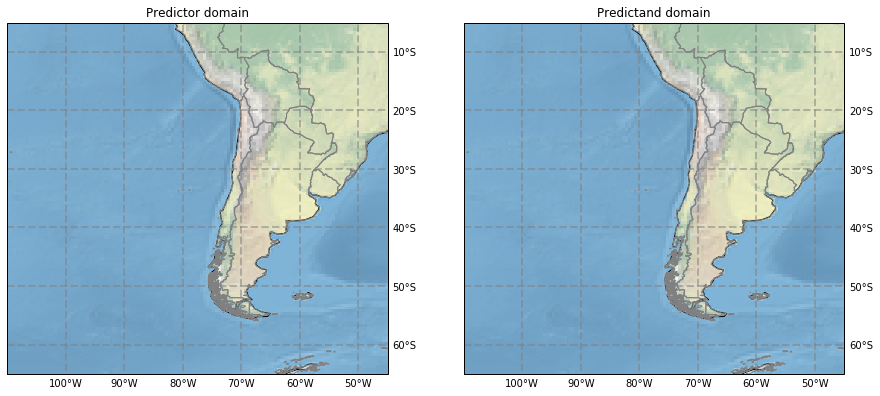

In [5]:
#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

plt.savefig("0_domain.png",dpi=300)
plt.close()

# Download data if necessary, and run CPT

In [5]:
mons=['Jan','Dec']
#mons=['Feb']
tgti='1.5'  #S: start for the DL
tgtf='3.5'   #S: end for the DL
#for now, just write the target period (for DL)
tgts=['Feb-Apr','Jan-Mar'] 
#tgts=['Mar-May']

#If downloadling data from several models, this section might take a while to be done
for model in models:
    print('')
    print('')
    print('----Starting process for '+model+'----')
    for mon in mons:
        tar=tgts[mons.index(mon)]
        print("New folder:")
        %cd $workdir/input

        print('Preparing CPT files for '+model+' and initialization '+mon+'...')
        PrepFiles(fprefix, PREDICTAND, threshold_pctle, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti, tgtf, mon, monf, fyr, os, wetday_threshold, tar, model, obs_source, hdate_last, force_download, station)
 
        print("New folder:")
        %cd $workdir/scripts

        CPTscript(model,PREDICTAND, mon,monf, fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station)

        print('Executing CPT for '+model+' and initialization '+mon+'...')
        try:
            subprocess.check_output(cptdir+'CPT.x < params > CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
        except subprocess.CalledProcessError as e:
            print(e.output.decode())
            raise
        print('----------------------------------------------')
        print('Calculations for '+mon+' initialization completed!')
        print('See output folder, and check scripts/CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt for errors')
        print('----------------------------------------------')
        print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')



----Starting process for CMC1-CanCM3----
New folder:
/home/laboratorio/PyCPT/Chile_seasonal_est/input
Preparing CPT files for CMC1-CanCM3 and initialization Jan...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/home/laboratorio/PyCPT/Chile_seasonal_est/scripts
Executing CPT for CMC1-CanCM3 and initialization Jan...
----------------------------------------------
Calculations for Jan initialization completed!
See output folder, and check scripts/CPT_stout_train_CMC1-CanCM3_Feb-Apr_Jan.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/home/laboratorio/PyCPT/Chile_seasonal_est/input
Preparing CPT files for CMC1-CanCM3 and initialization Dec...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file

## Deterministic Skill Analysis

Present folder:
/home/laboratorio/PyCPT/Chile_seasonal/output
CMC1-CanCM3
COLA-RSMAS-CCSM4
GFDL-CM2p5-FLOR-A06
NCEP-CFSv2

Spearman



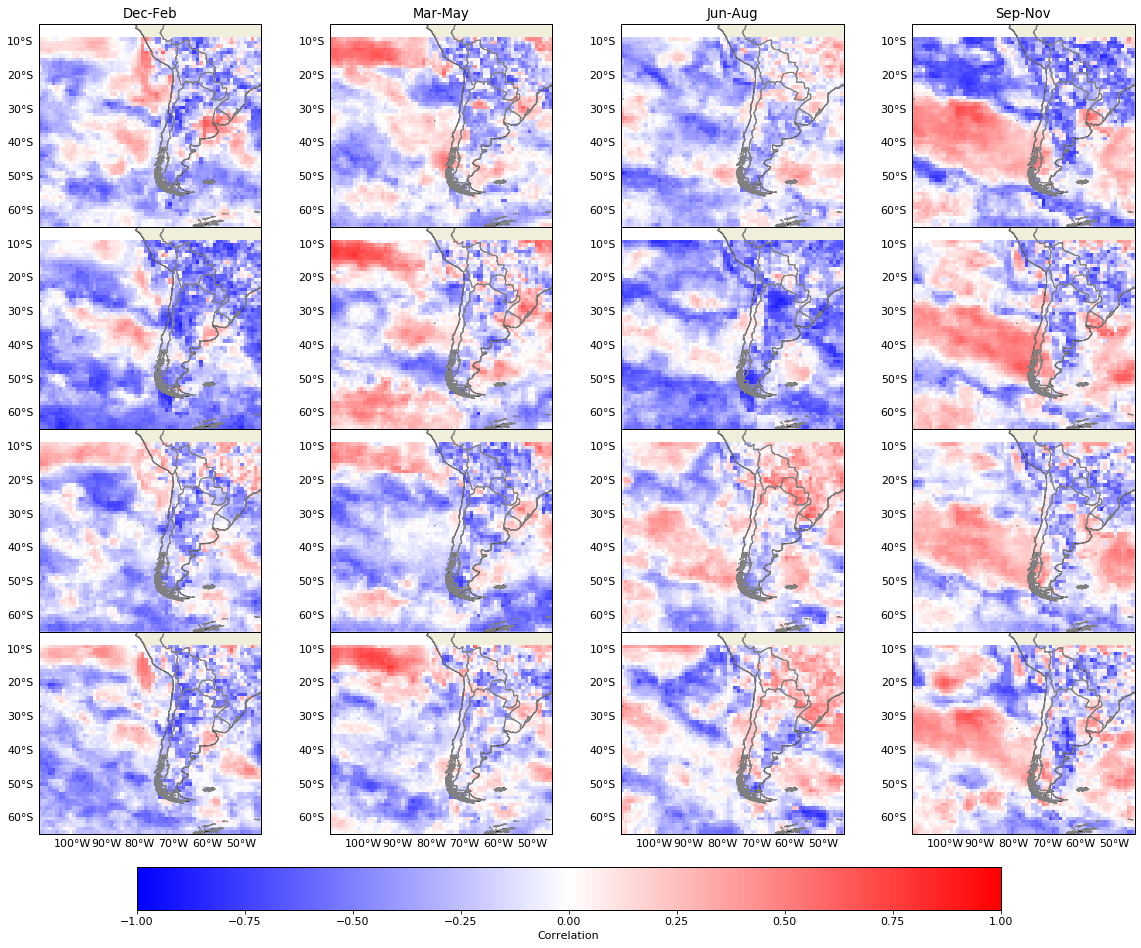

CMC1-CanCM3
COLA-RSMAS-CCSM4
GFDL-CM2p5-FLOR-A06
NCEP-CFSv2

2AFC



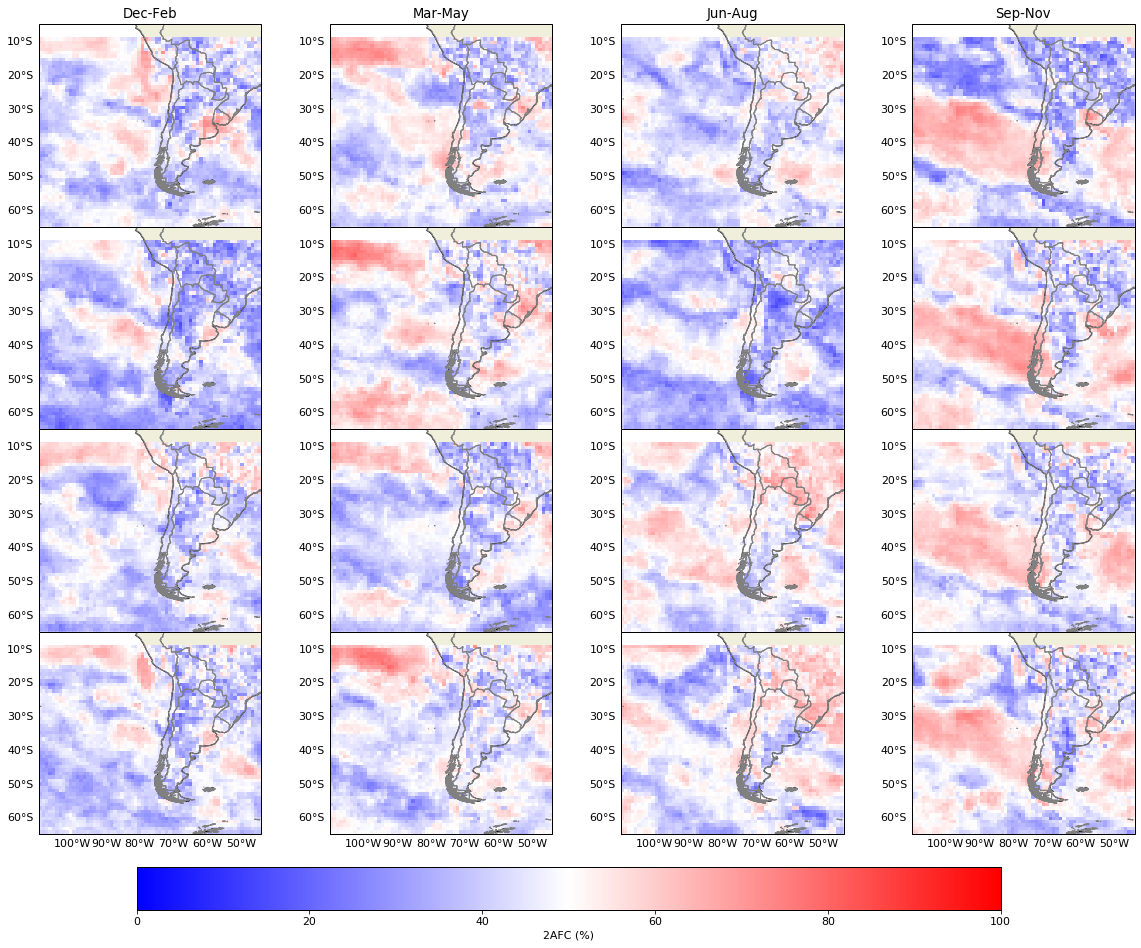

CMC1-CanCM3
COLA-RSMAS-CCSM4
GFDL-CM2p5-FLOR-A06
NCEP-CFSv2

RocAbove



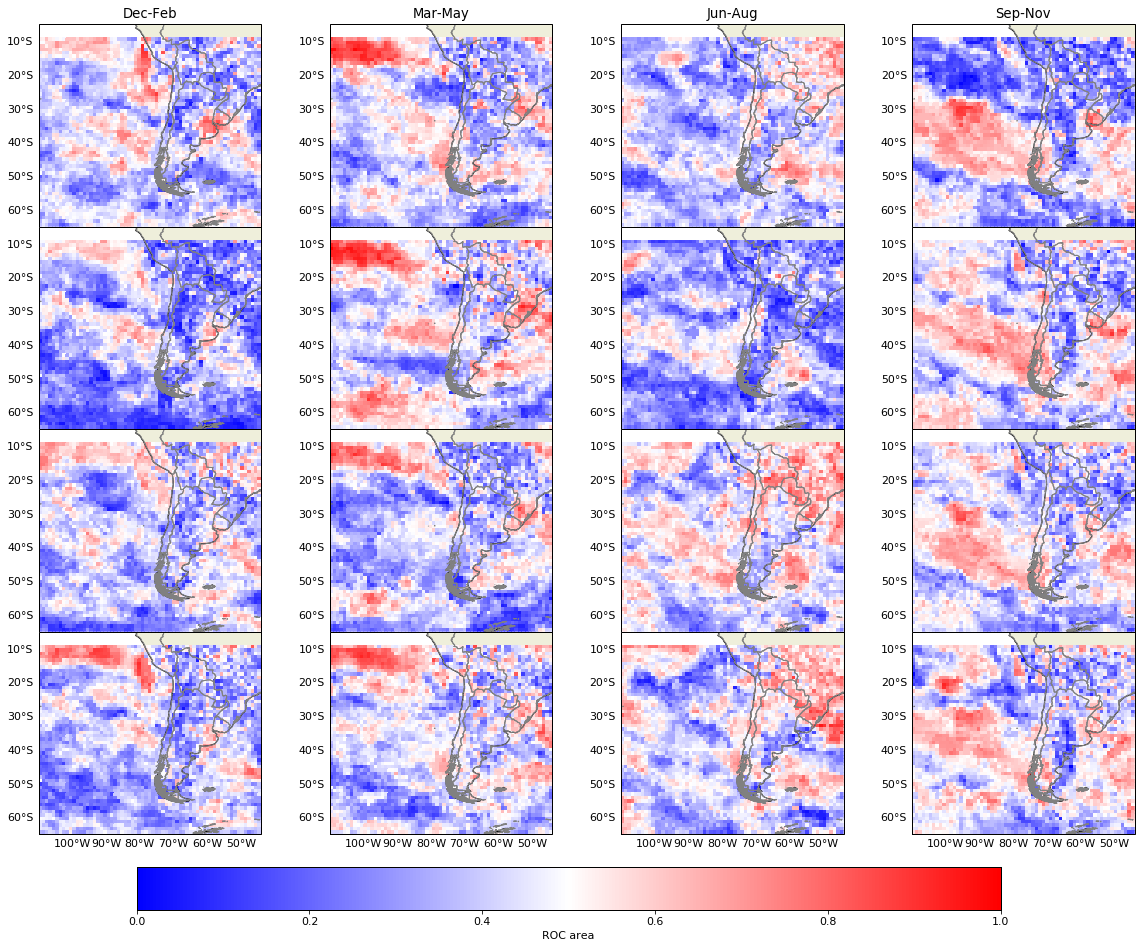

CMC1-CanCM3
COLA-RSMAS-CCSM4
GFDL-CM2p5-FLOR-A06
NCEP-CFSv2

RocBelow



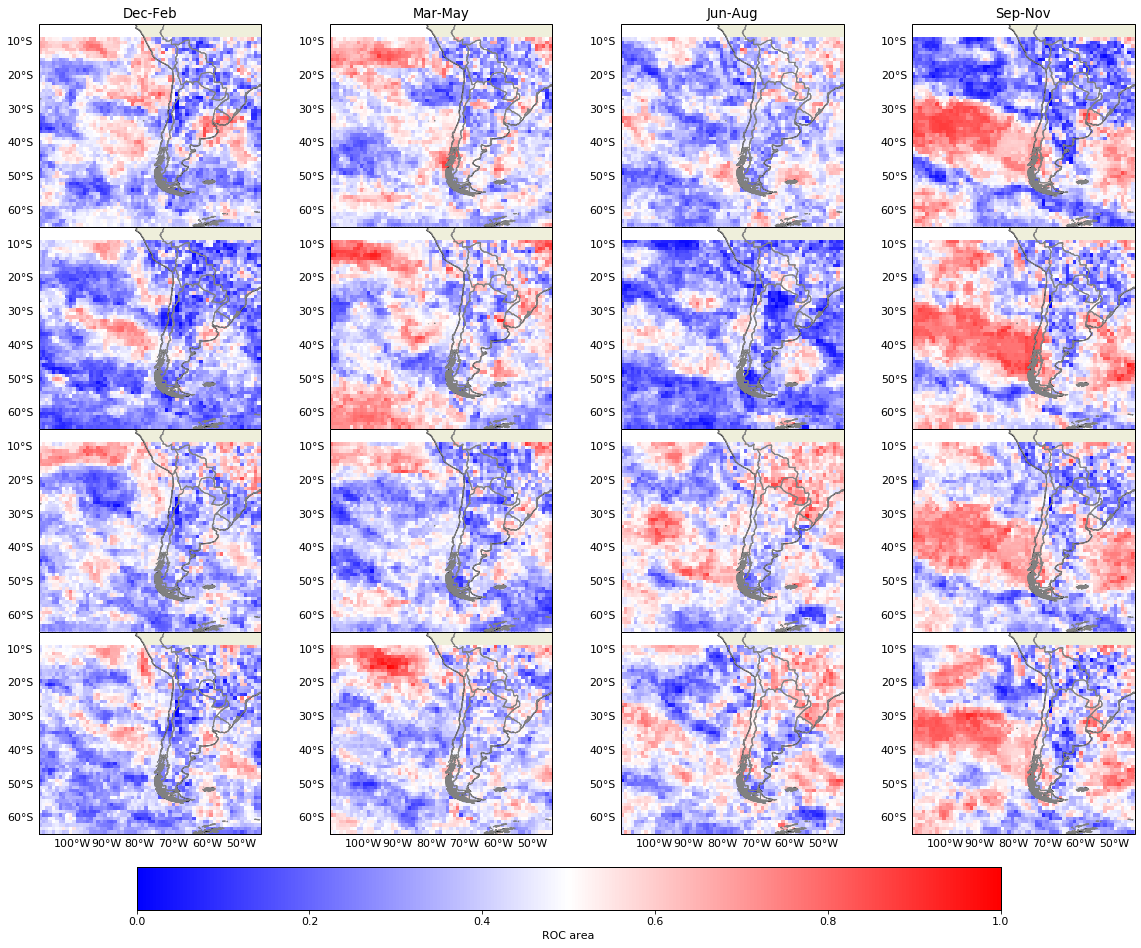

In [24]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow'):
met=('Spearman','2AFC','RocAbove','RocBelow')
monss=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']   #Needs to be any of the seasons computed.
#monss=['Mar-May'] 

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 11})
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss)   
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    #plt.show()
    print('')
    plt.savefig("1_"+ime+".png",dpi=300)
    #plt.close()
    plt.show()

## EOF Analysis (only available if MOS=PCR or CCA)

Present folder:
/home/laboratorio/PyCPT/Chile_seasonal/output


Mode 1


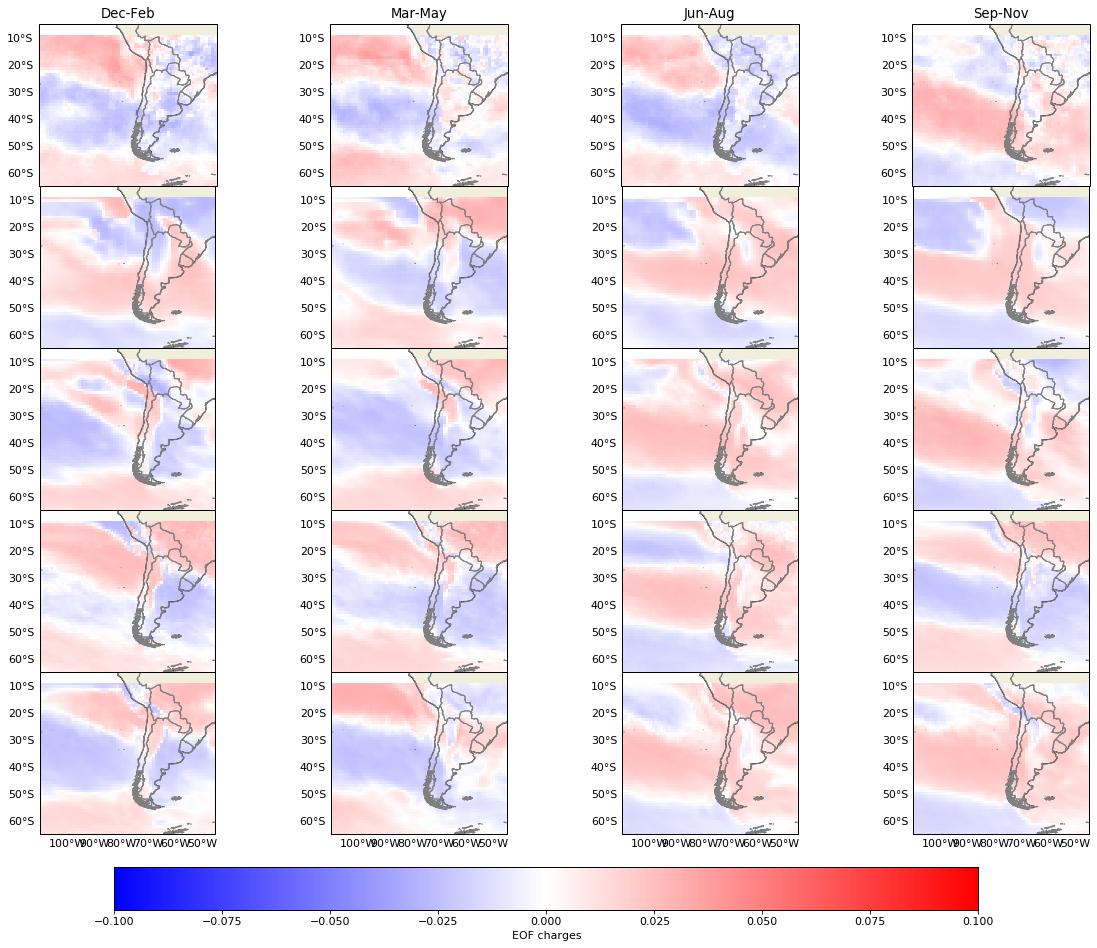

Mode 2


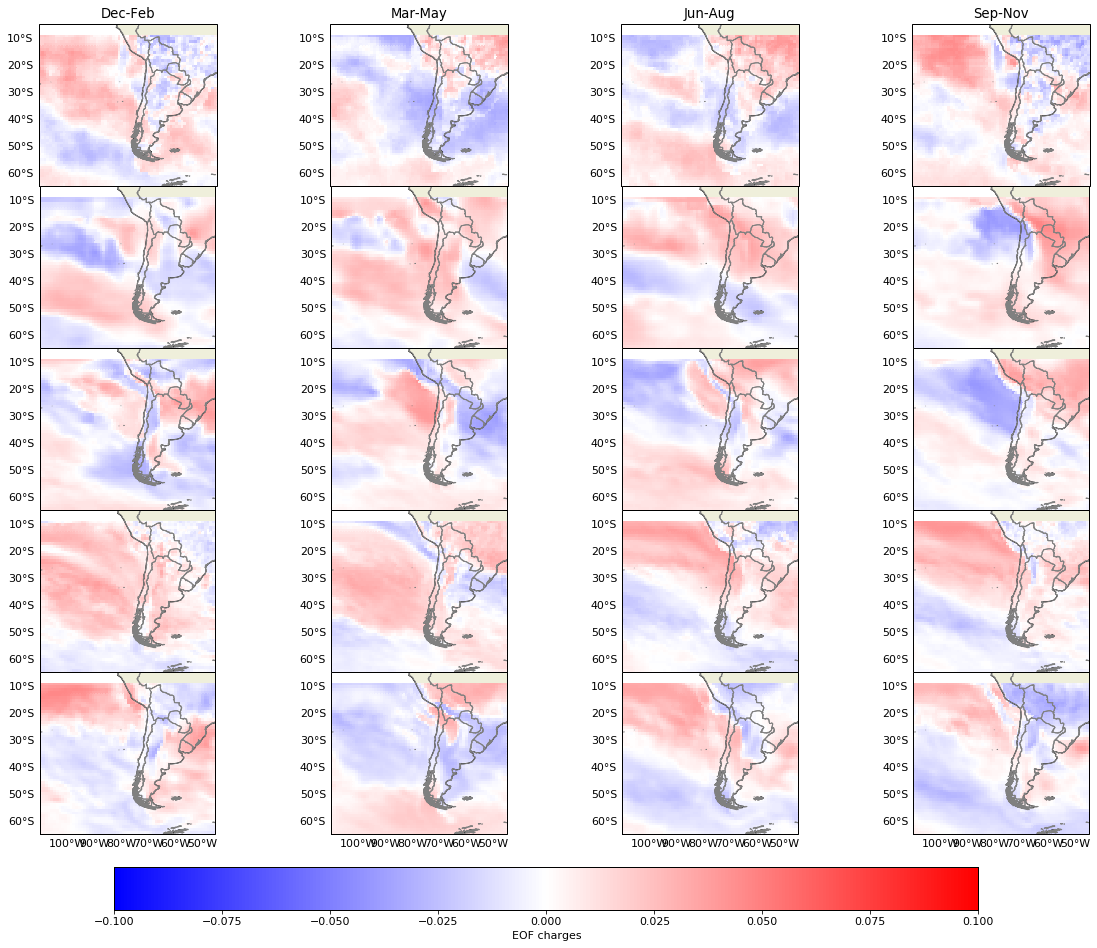

Mode 3


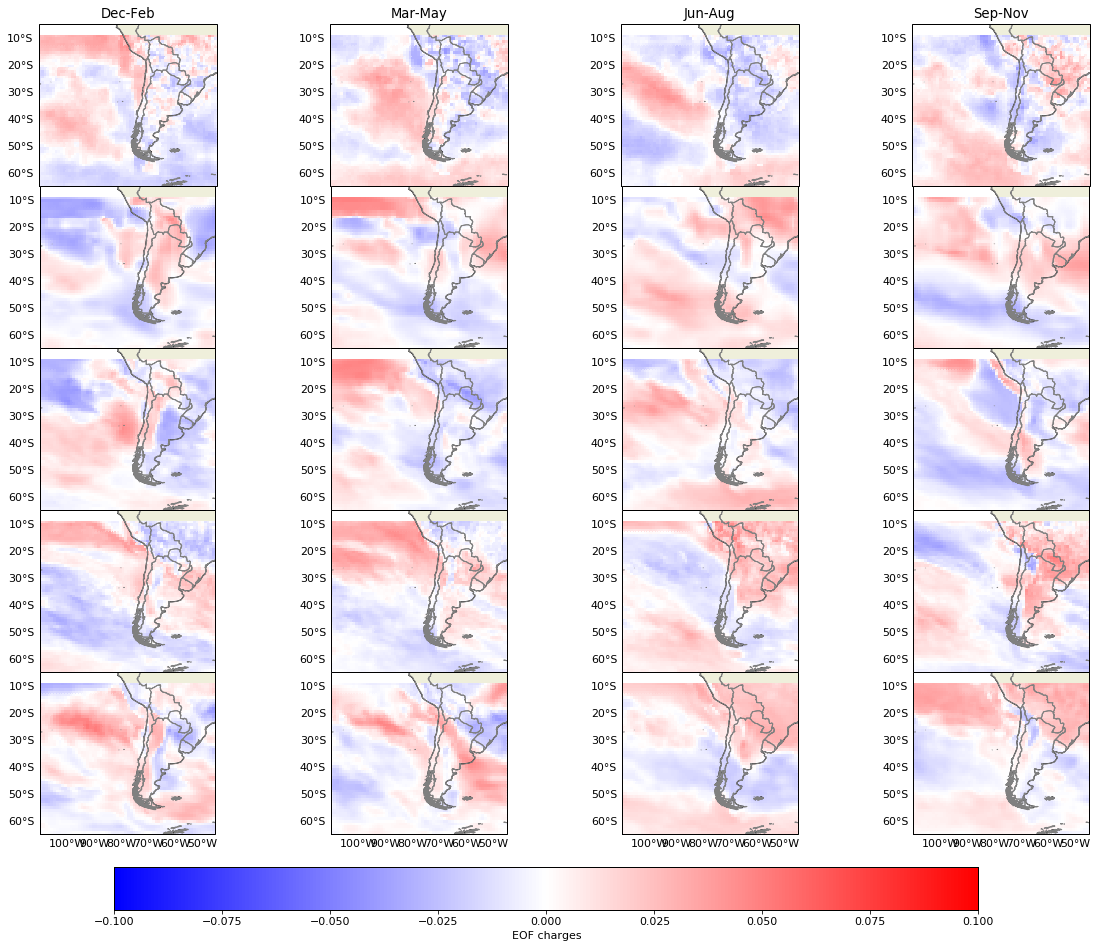

In [25]:
monss=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']   #Needs to be any of the seasons computed.
#monss=['Mar-May'] 

print("Present folder:")
%cd $workdir/output
print('')
print('')

# Skill scores loop
plt.rcParams.update({'font.size': 11})
nmodes=3
for imod in range(nmodes):
    plteofs(models,PREDICTAND,imod,nmodes,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mons,monss)   
    print("Mode "+str(imod+1))
    #plt.show()
    plt.savefig("2_eof"+str(imod+1)+".png",dpi=300)
    #plt.close()
    plt.show()

## Multi-model ensemble: NextGen

In [26]:
#List of selected models:
#models=['CMC2-CanCM4', 'GFDL-CM2p5-FLOR-A06','NCEP-CFSv2']
#models=['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']
models = ['CMC1-CanCM3', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'NCEP-CFSv2']

In [28]:
print('----Assessing skill for NextGen----')
model='NextGen'
MOS='None'   #we're changing here to no MOS to assess skill of NextGen
file='FCST_xvPr'

for mon in mons:
    tar=tgts[mons.index(mon)]
    print("New folder:")
    %cd $workdir/input

    print('Preparing CPT files for '+model+' and initialization '+mon+'...')
    NGensemble(models,fprefix,PREDICTAND,mpref,file,tar,mon,tgti,tgtf,monf,fyr)
    
    print("New folder:")
    %cd $workdir/scripts

    CPTscript(model,PREDICTAND, mon,monf, fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS)

    print('Executing CPT for '+model+' and initialization '+mon+'...')
    try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
    except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
    print('----------------------------------------------')
    print('Calculations for '+mon+' initialization completed!')
    print('See output folder, and check scripts/CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt for errors')
    print('----------------------------------------------')
    print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

----Assessing skill for NextGen----
New folder:
/home/laboratorio/PyCPT/Chile_seasonal/input
Preparing CPT files for NextGen and initialization Jan...
New folder:
/home/laboratorio/PyCPT/Chile_seasonal/scripts
Executing CPT for NextGen and initialization Jan...
----------------------------------------------
Calculations for Jan initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Feb-Apr_Jan.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/home/laboratorio/PyCPT/Chile_seasonal/input
Preparing CPT files for NextGen and initialization Feb...
New folder:
/home/laboratorio/PyCPT/Chile_seasonal/scripts
Executing CPT for NextGen and initialization Feb...
----------------------------------------------
Calculations for Feb initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Mar-May_Feb.txt for errors
----------------------------------------------
-------

Present folder:
/home/laboratorio/PyCPT/Chile_seasonal/output
NextGen

Spearman



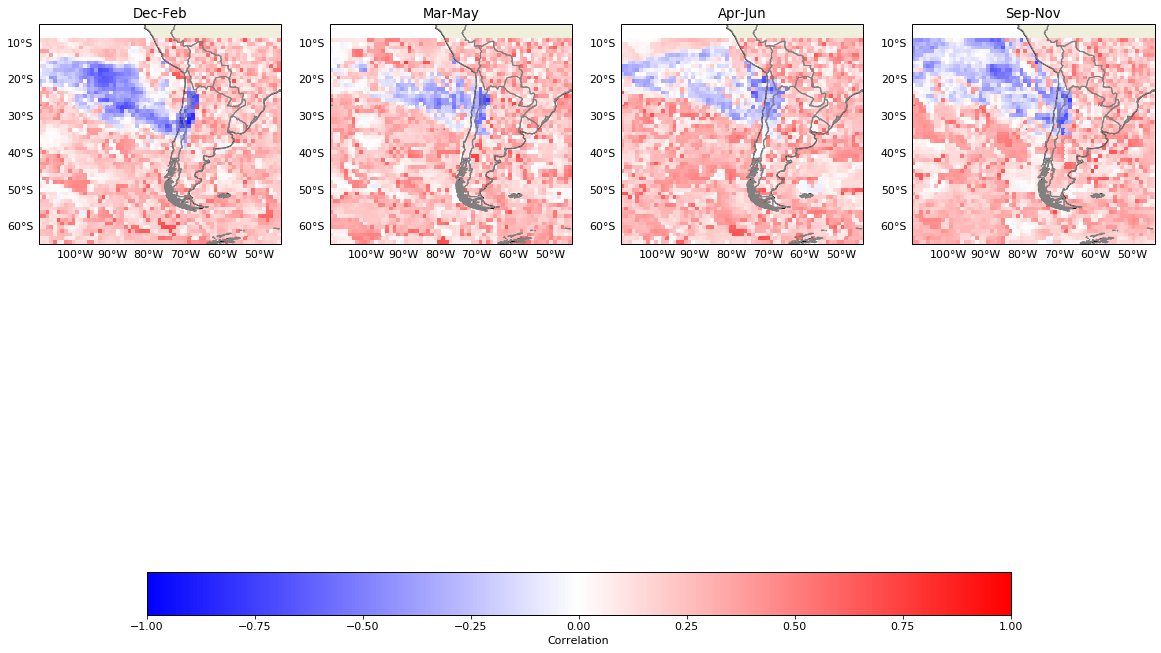

NextGen

2AFC



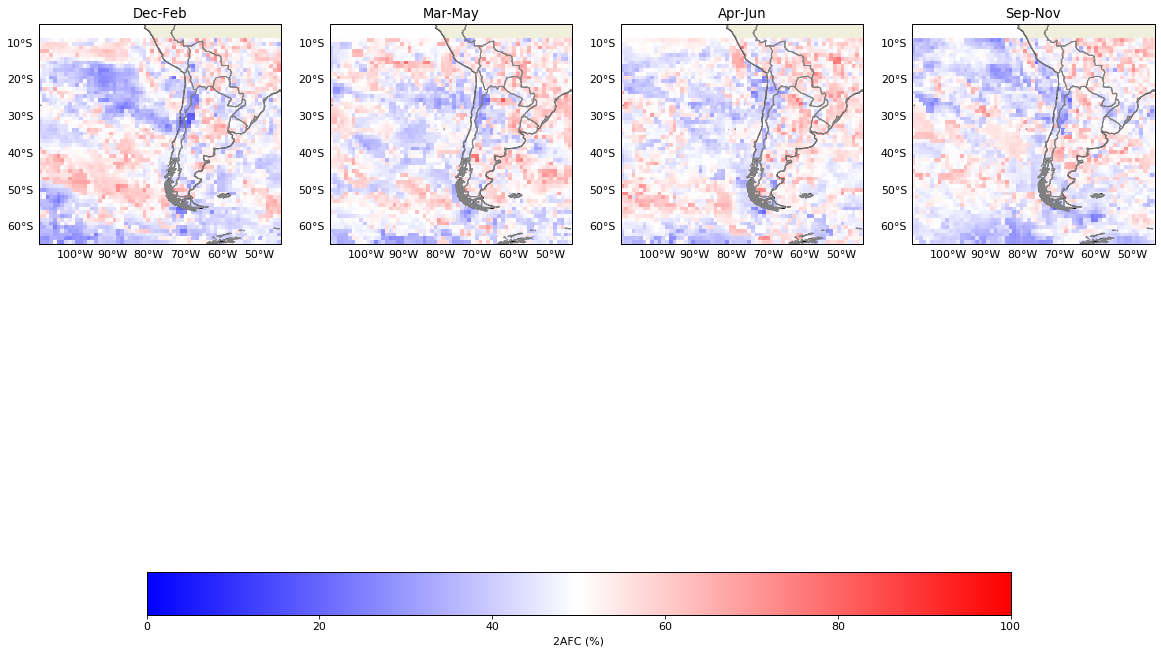

NextGen

RocAbove



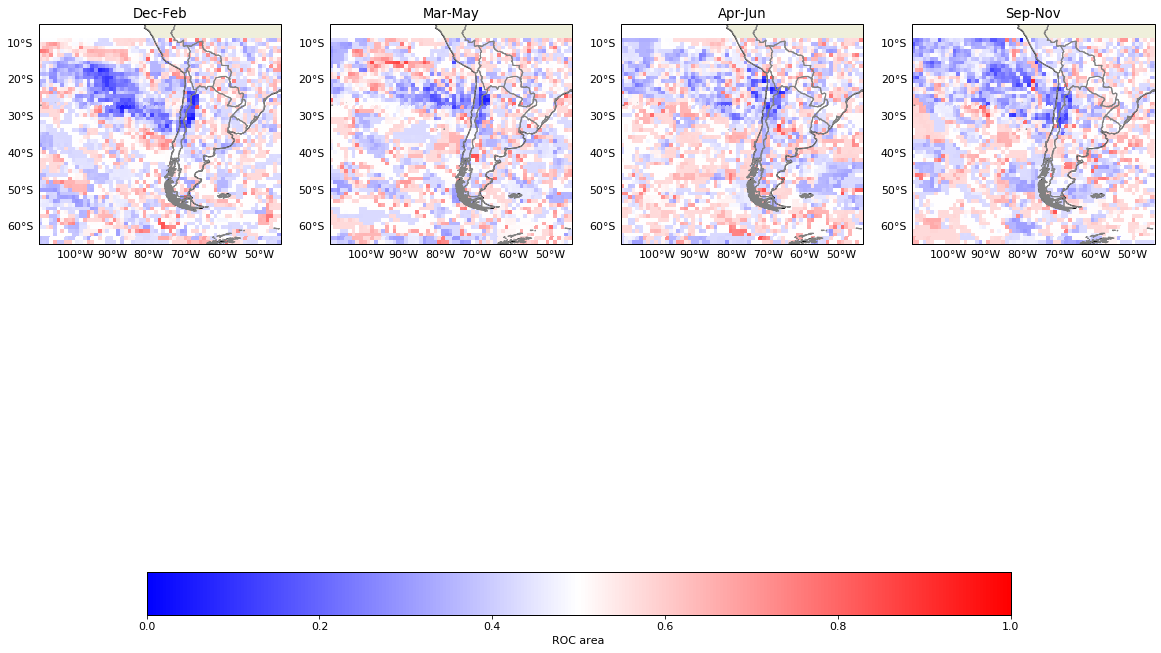

NextGen

RocBelow



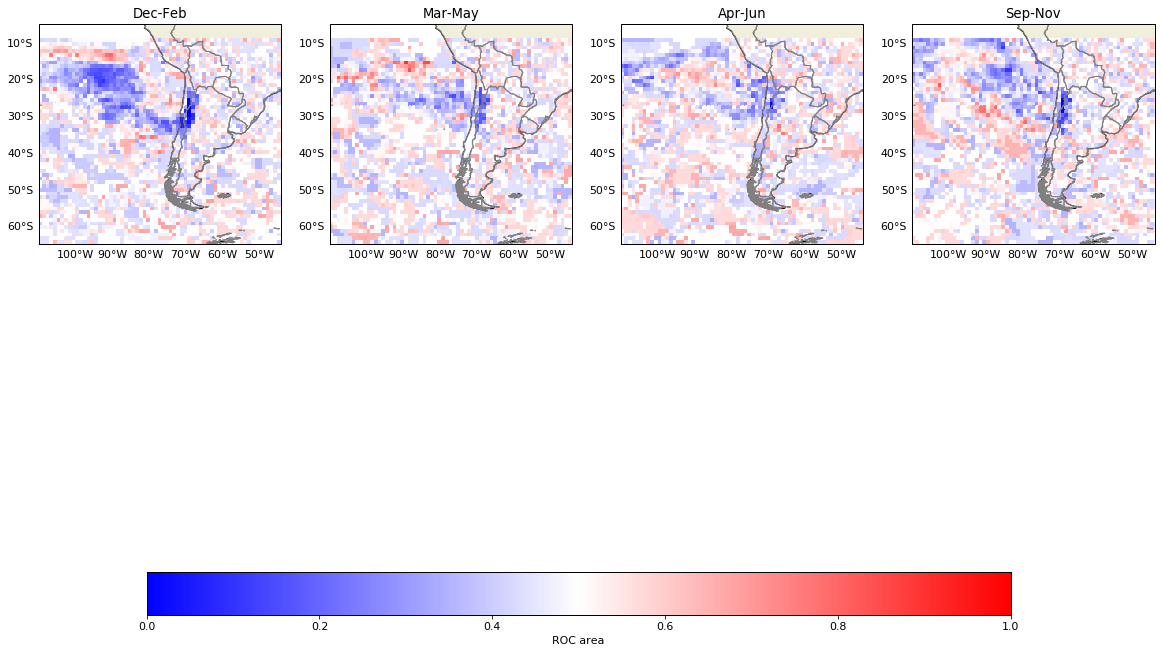

In [29]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow'):
met=('Spearman','2AFC','RocAbove','RocBelow')
monss=['Dec-Feb','Mar-May','Apr-Jun','Sep-Nov']   #Needs to be any of the seasons computed.
#monss=['Mar-May'] 
modelo=['NextGen']

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 11})
for ime in met:
    pltmap(modelo,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss)   
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    #plt.show()
    print('')
    plt.savefig("3_nextGen"+ime+".png",dpi=300)
    plt.show()

In [38]:
print("Present folder:")
%cd $workdir/output
ensemblefiles(modelo,work)

Present folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/output
mkdir: ../output/NextGen/: File exists
cp: ../*NextGen*.txt: No such file or directory
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Apr-Jun_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Aug-Oct_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Dec-Feb_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Feb-Apr_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Jan-Mar_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Jul-Sep_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Jun-Aug_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Mar-May_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_May-Jul_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Nov-Jan_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Oct-Dec_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_Obs_Sep-Nov_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_mu_Apr-Jun_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_mu_Aug-Oct_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_mu_Dec-Feb_May2019.txt
a CMC1-CanCM3_PRCP_CCAFCST_mu_Feb-Apr_May2019.txt
a

a COLA-RSMAS-CCSM4_PRCP_PCRFCST_mu_Jun-Aug_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_mu_Mar-May_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_mu_May-Jul_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_mu_Nov-Jan_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_mu_Oct-Dec_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_mu_Sep-Nov_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Apr-Jun_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Aug-Oct_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Dec-Feb_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Feb-Apr_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Jan-Mar_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Jul-Sep_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Jun-Aug_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Mar-May_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_May-Jul_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Nov-Jan_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Oct-Dec_May2019.txt
a COLA-RSMAS-CCSM4_PRCP_PCRFCST_var_Sep-Nov_May2019.tx

a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Apr-Jun_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Aug-Oct_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Dec-Feb_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Feb-Apr_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Jan-Mar_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Jul-Sep_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Jun-Aug_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Mar-May_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_May-Jul_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Nov-Jan_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Oct-Dec_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_Obs_Sep-Nov_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Apr-Jun_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Aug-Oct_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Dec-Feb_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Feb-Apr_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Jan-Mar_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Jul-Sep_May2019.txt
a NASA-GEOSS2S_PRCP_CCAFCST_mu_Jun-Aug_May2019.txt
a NASA-GEOSS2S_PRCP

### Flexible Forecasts

Folder:
/home/laboratorio/PyCPT/Chile_seasonal/output


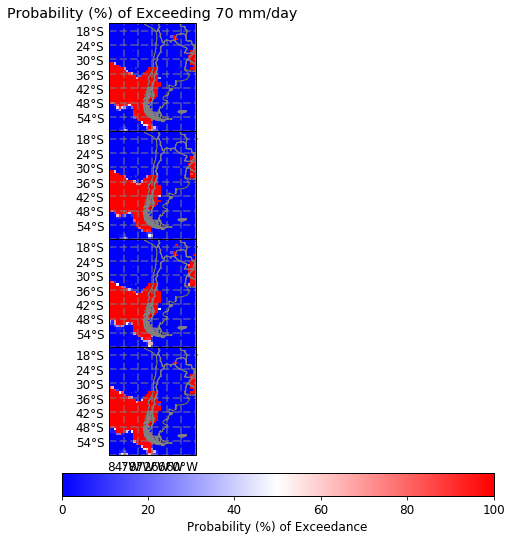

In [15]:
flexformat_threshold = 70 #threshold for the flexible format map

#CPC: Al parecer lluvia total trimestral
#CHIRPS: mm/dia

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltmapff(models,PREDICTAND,flexformat_threshold,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)
#plt.savefig("ProbFcst_Flex.pdf", dpi=300)

Folder:
/home/laboratorio/PyCPT/Chile_seasonal/output


<Figure size 1080x1080 with 0 Axes>

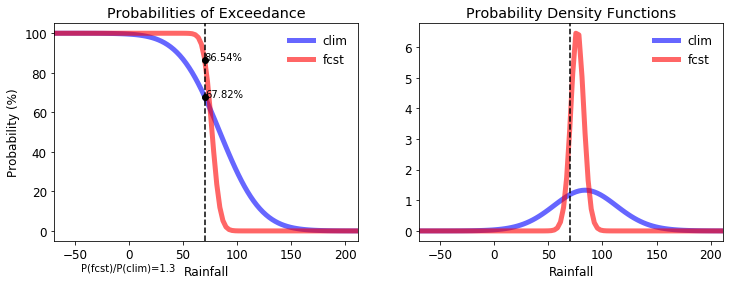

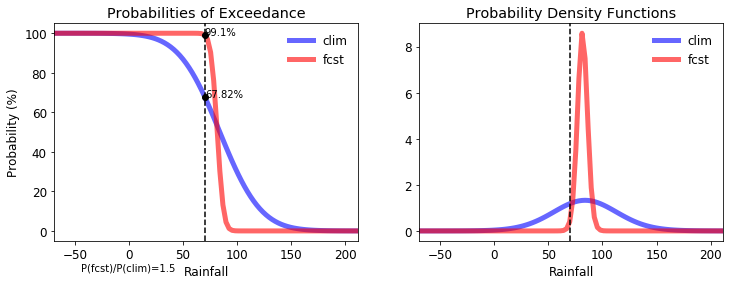

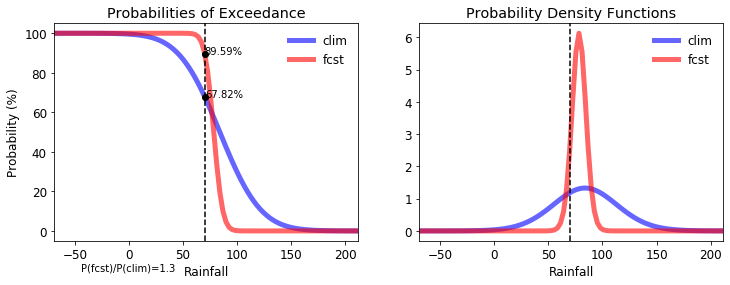

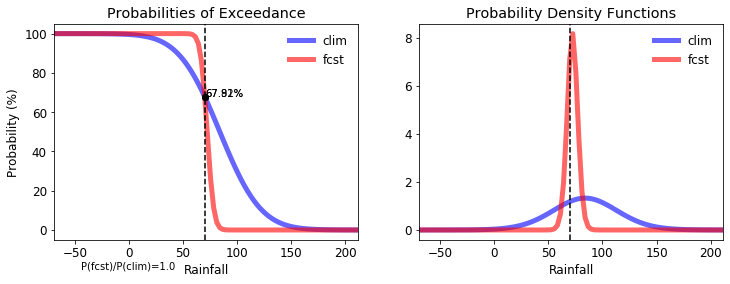

In [16]:
#flexformat_threshold = 10. #threshold for the flexible format map (in mm/week)
lon=-71.
lat=-33.
 
print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(models,PREDICTAND,flexformat_threshold,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)
plt.savefig("ProbExceed.pdf", dpi=300)